# Load packages and define functions

In [1]:
# !pip install SciFiReaders
!pip install igor2
!pip install gdown==v4.7.3
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [2]:
# import SciFiReaders
# from SciFiReaders import IgorIBWReader

import numpy as np
import matplotlib.pyplot as plt
import os
from igor2 import binarywave as bw

In [3]:
# @title
class IBWData:
    def __init__(self, header=None, channels=None, data=None, size=None):
        self.header = header if header is not None else {}
        self.channels = channels if channels is not None else []
        self.data = data if data is not None else []

    def __repr__(self):
        return f"IBWData(header={self.header}, channels={self.channels}, data={self.data})"

def load_ibw(file, ss=False):
    '''
    Load the ibw file into an IBWData object.
    It automatically creates three default attributes:
      1. header: a dict contains all the setup information
      2. channels: a list of channel names for each image data
      3. data: an array of all the saved image data in this ibw file
    '''
    t = bw.load(file)
    wave = t.get('wave')

    # Decode the notes section to parse the header
    if isinstance(wave['note'], bytes):
        try:
            parsed_string = wave['note'].decode('utf-8').split('\r')
        except:
            parsed_string = wave['note'].decode('ISO-8859-1').split('\r')
    header = {}
    for item in parsed_string:
        try:
            key, value = item.split(':', 1)
            value = value.strip()  # Remove leading/trailing whitespace
        except ValueError:
            continue  # For items that do not split correctly

        # Determine the data type of the value and convert
        if '.' in value or 'e' in value:  # Floating point check
            try:
                header[key] = float(value)
            except ValueError:
                header[key] = value
        elif value.lstrip('-').isdigit():  # Integer check
            header[key] = int(value)
        else:
            header[key] = value

    # Transpose the data matrix
    data = wave['wData'].T
    # data = wave['wData']

    # Extract channel data types from the header
    channels = [header.get(f'Channel{i+1}DataType', 'Unknown') for i in range(np.shape(data)[0])]
    out = IBWData(header, channels, data)
    out.size = header['ScanSize']
    out.mode = header['ImagingMode']
    if out.mode == "PFM Mode":
        if len(out.channels) > 4:
            out.mode = "DART Mode"
            out.channels = ['Height', 'Amplitude1', 'Amplitude2', 'Phase1', 'Phase2', 'Frequency']
        else:
            out.channels = ['Height', 'Amplitude', 'Deflection', 'Phase']

    # Load the switching spectroscopy (hysteresis loop) data
    if ss is not False:
        bias_raw= data[-1]
        index_values = np.where(~np.isnan(bias_raw))

        bias = bias_raw[index_values]
        amp, phase1, phase2 = data[2][index_values], data[3][index_values], data[4][index_values]
        index_bp = np.where(np.diff(bias) != 0)[0] + 1
        index_bp = np.concatenate([[0], index_bp])

        length = len(index_bp) // 2

        bias_on = np.zeros(length)

        phase1_on = np.zeros(length)
        phase1_off = np.zeros(length)

        phase2_on = np.zeros(length)
        phase2_off = np.zeros(length)

        amp_on = np.zeros(length)
        amp_off = np.zeros(length)

        for i in range(length * 2-1):
            if i % 2 == 0: # bias off
                phase1_off[i//2] = np.mean(phase1[index_bp[i]:index_bp[i+1]])
                phase2_off[i//2] = np.mean(phase2[index_bp[i]:index_bp[i+1]])
                amp_off[i//2] = np.mean(amp[index_bp[i]:index_bp[i+1]])
            else:
                bias_on[i//2] = np.mean(bias[index_bp[i]:index_bp[i+1]])
                phase1_on[i//2] = np.mean(phase1[index_bp[i]:index_bp[i+1]])
                phase2_on[i//2] = np.mean(phase2[index_bp[i]:index_bp[i+1]])
                amp_on[i//2] = np.mean(amp[index_bp[i]:index_bp[i+1]])
        out.bias = bias_on
        out.phase1_on = phase1_on
        out.phase1_off = phase1_off
        out.phase2_on = phase2_on
        out.phase2_off = phase2_off
        out.amp_on = amp_on * np.cos(phase1_off/180*np.pi)
        out.amp_off = amp_off * np.cos(phase1_off/180*np.pi)
        out.data = data
    # Return an IBWData object
    return out


In [4]:
# Function to read and plot all the ibw files

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def display_ibw_folder(folder, mode=None, key=['Height'], paras=None, save=None):
    '''
    Display all the ibw with specified modes in a given folder.

    Input:
        folder  - Required: path to the folder to be explored
        mode    - Optional: if not given, all available modes will be displayed
                            can be 'AC Mode', 'PFM Mode', 'Contact Mode',
                            To be added: 'DART Mode', 'SKPM Mode'
        key     - Optional: list of channels to be displayed
        paras   - Optional: to be added for visualizing parameters

    Output:
        ibw_files   -list: ibw file names in the same order as they are displayed
        data        -list: SciFiReader object of each ibw file displayed

    Example use:
        ibw_files, data = display_ibw(folder, mode='AC Mode', key=['Height', 'ZSensor'], paras=None)
    '''
    file_names = os.listdir(folder)
    file_names = sorted(file_names)

    file_displayed = []
    out = []

    # if key != None:
    #   if not isinstance(key, list):
    #       key = list(key)

    # n_cols = len(key)
    # chennel_dict = {
    #     'AC Mode':      ['Height', 'Amplitude', 'Phase', 'ZSensor'],
    #     'PFM Mode':     ['Height', 'Amplitude', 'Phase', 'Deflection'],
    #     'DART Mode':    ['Height', 'Amplitude1', 'Phase1', 'Frequency', 'Amplitude2', 'Phase2'],
    #     'Contact Mode': ['Height', 'Amplitude', 'Phase', 'Deflection'],
    # }

    display_index = 0
    for index, file in enumerate(file_names):
        if file.endswith('.ibw'):
            fname = os.path.join(folder, file)
            try:
                t = load_ibw(fname)
            except TypeError:
                pass
            if len(t.data.shape) == 3: # skip the spectrum ibw files
                if mode == None:
                    display_ibw(t, key=key, display_index=display_index, save=save)
                    file_displayed.append(fname)
                    out.append(t)
                    display_index += 1
                elif mode == t.mode:
                    display_ibw(t, key=key, display_index=display_index, save=save)
                    file_displayed.append(fname)
                    out.append(t)
                    display_index += 1
            else:
                pass

    return file_displayed, out

def display_ibw(file, key=None, titles=None, save=None, display_index=None):
    '''
    Display a single ibw  file with specified channel to display.

    Input:
        file    - Required: path to the file to be displayed
        key     - Optional: list of channels to be displayed
        titles  - Optional: list of titles to overrid the channel names in the plot
        save    - Optional: controls whether the image will be saved. Default: None.
                          if provided, the image displayed will be saved as "save.png"

    Output:
        data    - IBWData object: object contains all the information in the ibw file

    Example use:
        data = display_ibw(file, key=['Height', 'ZSensor'], save="SaveName")
    '''
    try:
        if type(file) is str:
            t = load_ibw(file)
        else:
            t = file

        if len(t.data.shape) == 3: # skip the spectrum ibw files
            indices = find_channel(obj=t, key=key)
            if len(indices) == 1: # Only one channel will be displayed
                plt.figure(figsize=[4,4])
                to_plot = t.data[indices[0]]
                im = plt.imshow(to_plot, extent=[0, t.size*1e6, 0, t.size*1e6])
                title = "{}: {}-{}".format(display_index, t.mode, key[0]) if not titles else titles
                plt.title(title)
                divider = make_axes_locatable(plt.gca())
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                plt.tight_layout()
                if save is not None:
                    plt.savefig('{}.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)
            else:
                n_cols = len(indices)
                fig,ax=plt.subplots(1, n_cols, figsize=[n_cols*3+1, 3])
                for i in range(len(indices)):
                    to_plot = t.data[indices[i]]
                    im = ax[i].imshow(to_plot, extent=[0, t.size*1e6, 0, t.size*1e6])
                    # fig.colorbar(im, ax=ax[i])
                    divider = make_axes_locatable(ax[i])
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    fig.colorbar(im, cax=cax)
                    if titles is None:
                        if not i:
                            ax[i].set_title("{}: {}-{}".format(display_index, t.mode, t.channels[indices[i]]))
                        else:
                            ax[i].set_title("{}".format(t.channels[indices[i]]))
                    else:
                        ax[i].set_title(titles[i])
                    plt.tight_layout()
                    if save is not None:
                        plt.savefig('{}.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)
        else:
            pass
    except TypeError:
        pass

# Help function to find the index of corresponding channel key
def find_channel(obj, key):
    if key is None:
        return np.arange(len(obj.channels))
    else:
        index = []
        channels = obj.channels

        for item in key:
            if item in channels:
                index.append(channels.index(item))
        return index

# Load the data

In [5]:
!gdown https://drive.google.com/drive/folders/1GpE5TvpTZXraYiNPBo_IawlvL2eNiSQc?usp=share_link --folder

Retrieving folder contents
Processing file 1-nWaqbxopSuxhY4vSuNZuv2k27sNkEYq H120009.ibw
Processing file 1lmoKgb1kaoS2-X2L4BsxDE1eTnsoDW49 H120010.ibw
Processing file 1o3dtrzVOajuR8VJuUojl0f0uGY6XC28u HeightCali0001.ibw
Processing file 1EIVtqoWSYVOGfbHs8qTg4lDVHxViNwXy HeightCali0026.ibw
Processing file 1o5y7lFDyetCHN5-XfRGJFJr7lbA8jOaP Image0000.ibw
Processing file 1ptqQl86gPq-rsTu2UM348u8zh7Ucx0Nz Image0001.ibw
Processing file 1kqJFWdwJxnTYJ6HtwKWqZSZXMX3D3irs Image0002.ibw
Processing file 1MkX976h3wm2Q6F51l7z_F5MoM5eppseW PFM_sf_HVS0001.ibw
Processing file 1NTpPBhH3aTpXaITknuh2yjyWTs6RldIA PTO_DART_AE4_0059.ibw
Processing file 1YS7ysMOI6dszNg3oG8phWZp3kwy07EOw PTO_DART_AE4_0068.ibw
Processing file 1hOMtf6db24timKdpLWsKG5DJ7CVVRfy0 PTO_Loc2_SS_0002.ibw
Processing file 1EcOOJIGC_eHBGoUzuPAjW5f7dtIAvFgv PTO_Loc5_SS_0004.ibw
Processing file 1hzJRaCMGU28rc8SOtO7-9_RhOBJrD7jn PZT_No_10026.ibw
Processing file 1O3lZOdU7owW54aZK1dwqqnKyK3roSrnM PZT_No_10036.ibw
Retrieving folder contents com

In [6]:
!ls

ibw  sample_data


# Don't specify imaging mode -- display all the modes

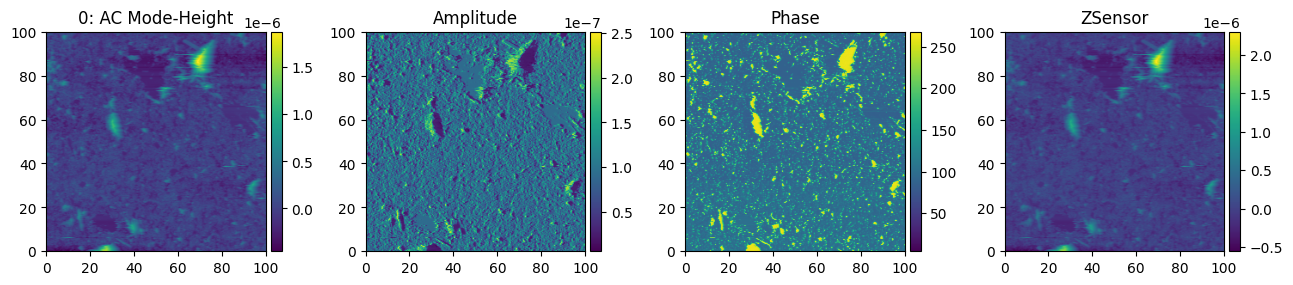

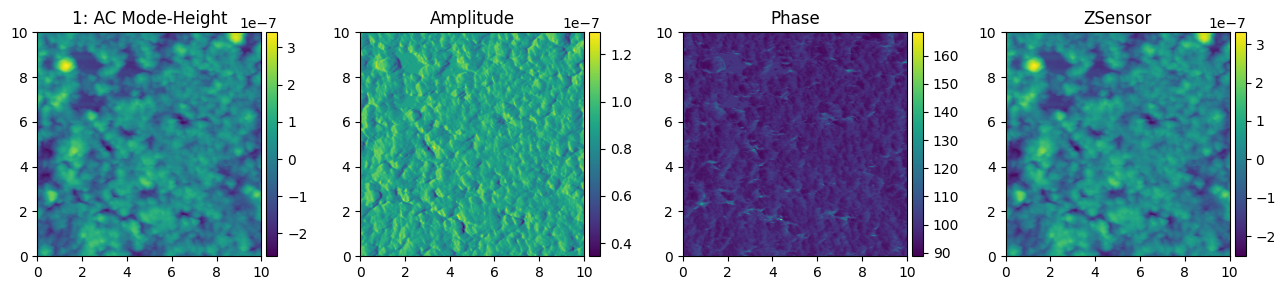

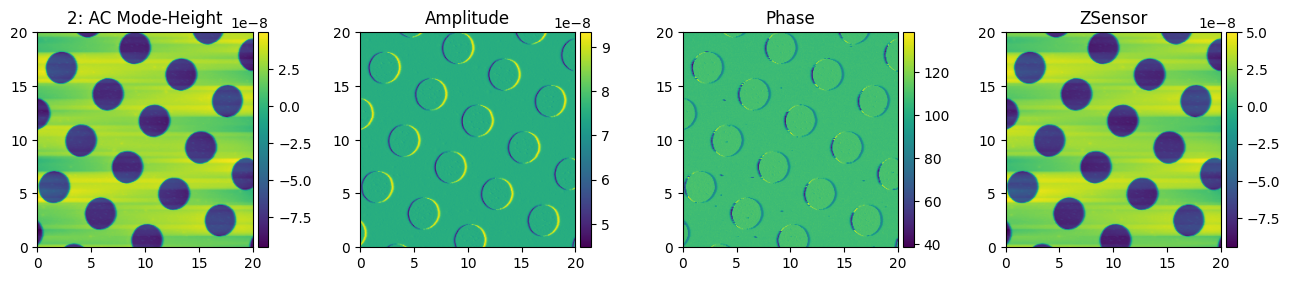

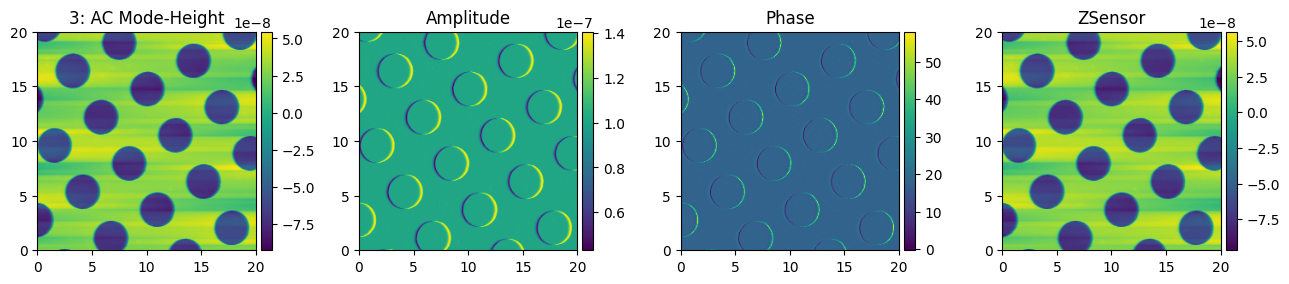

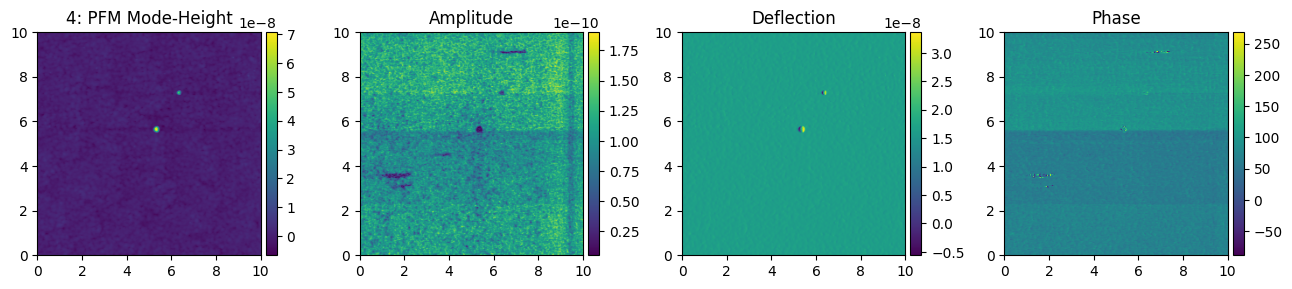

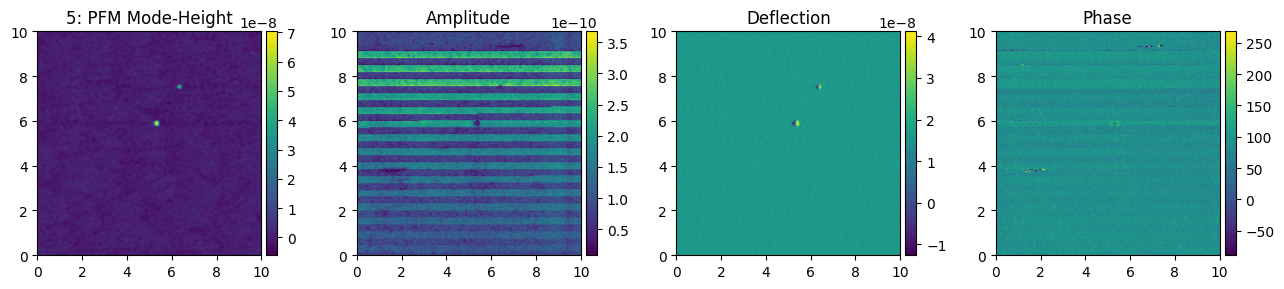

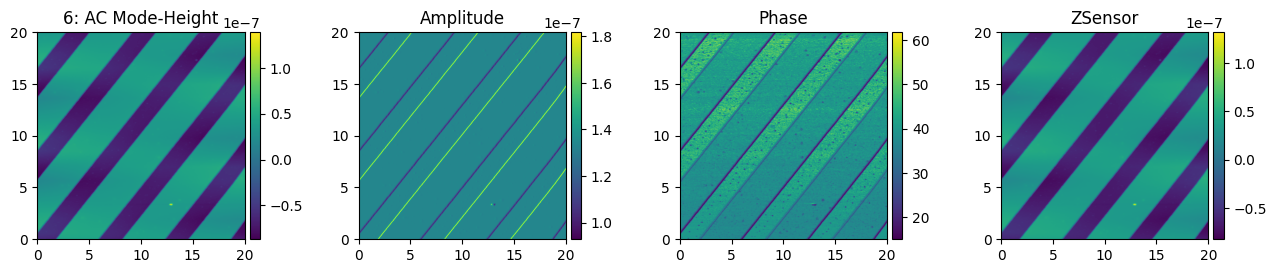

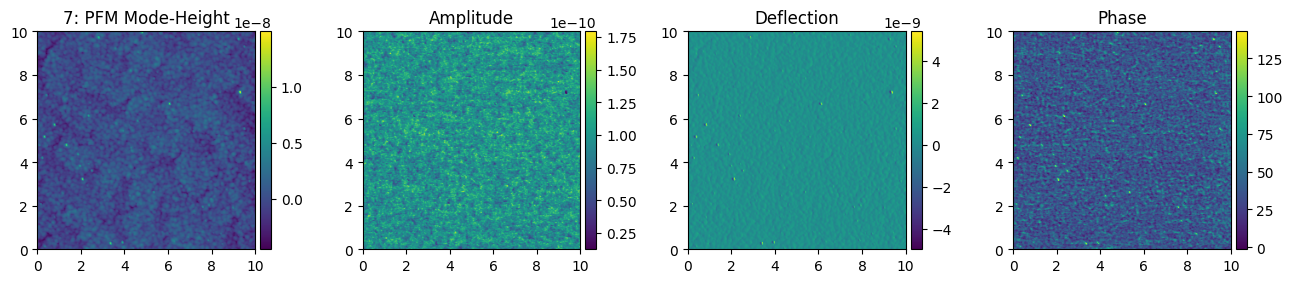

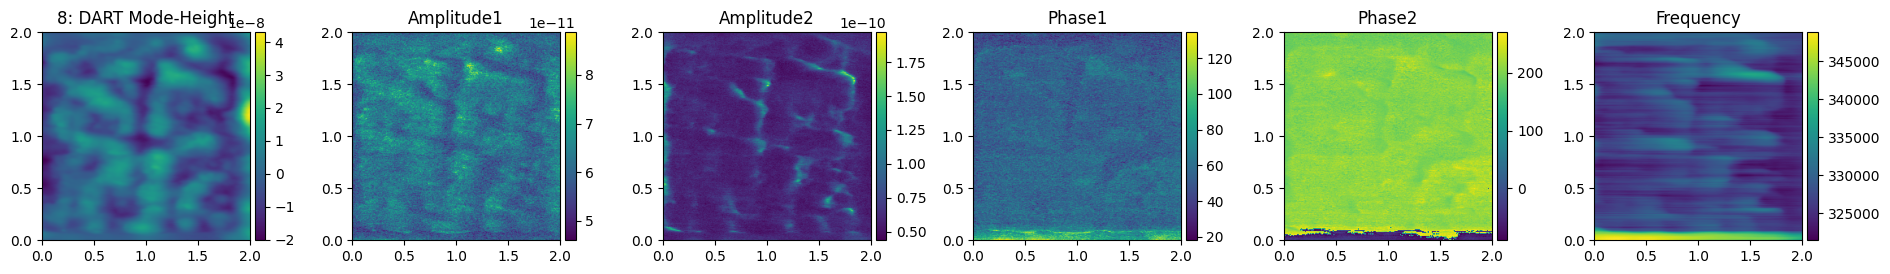

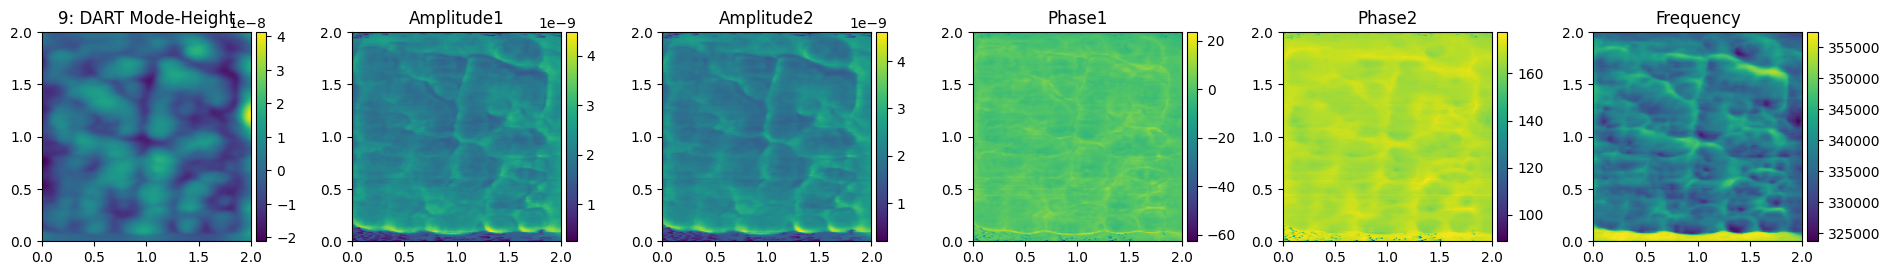

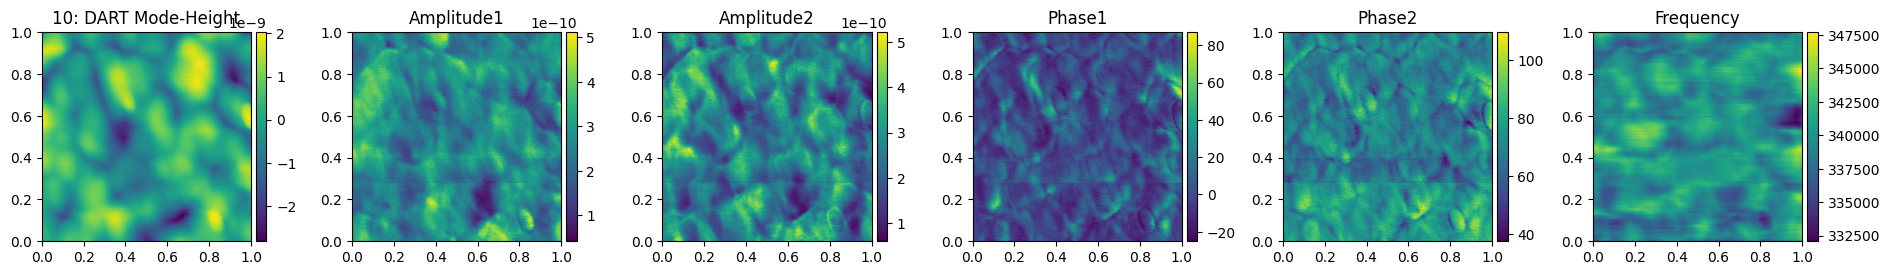

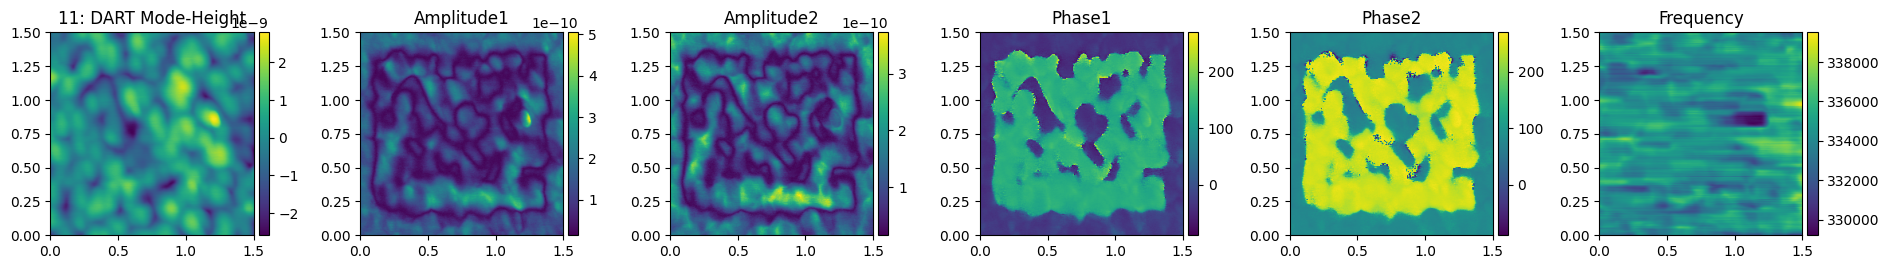

In [7]:
# If mode and key are both None, every channel in every image file will be displayed
folder = 'ibw'

fnames, ibw_data = display_ibw_folder(folder=folder, mode=None, key=None)

In [8]:
# # Find the good ibw images and then you can either save them to a separate folder of save the plot of them
# good_index = [0, 11, 12,]

# for ix in good_index:
#     print(fnames[ix])

# Specify the mode -- only show the specified mode

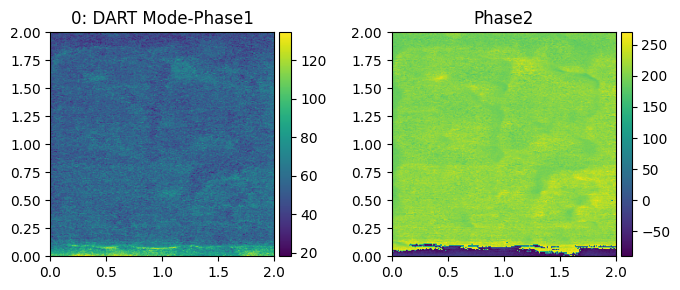

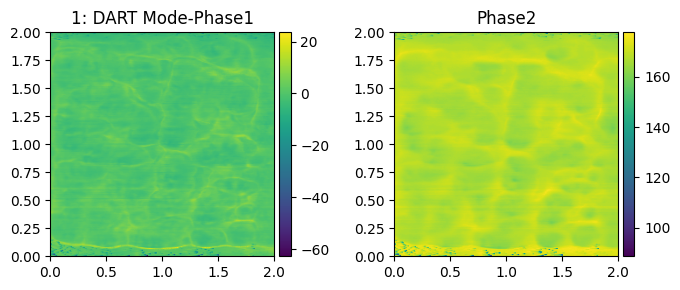

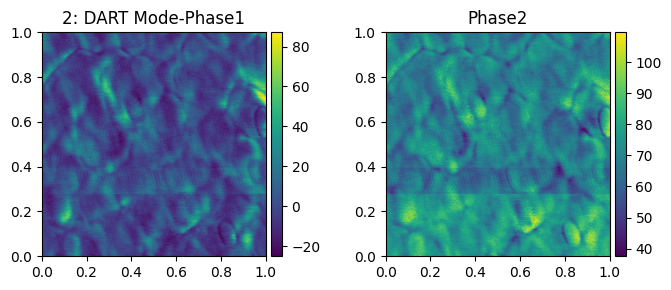

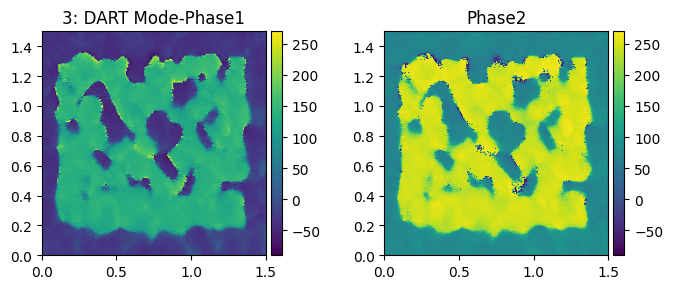

In [9]:
# Let's only show the two phase channels in the DART mode:
folder = 'ibw'

fnames, ibw_data = display_ibw_folder(folder=folder, mode='DART Mode', key=['Phase1', 'Phase2'])

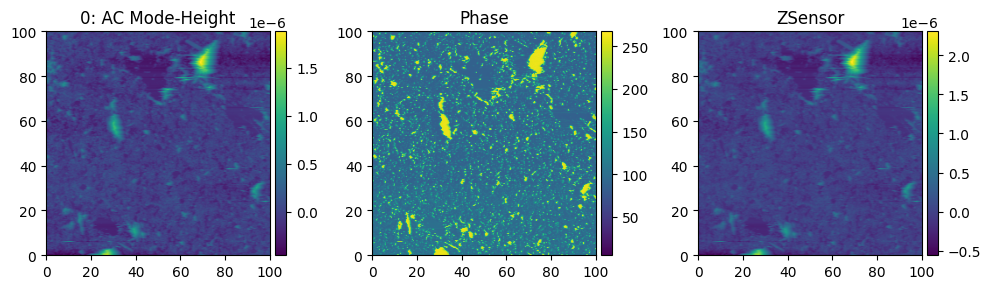

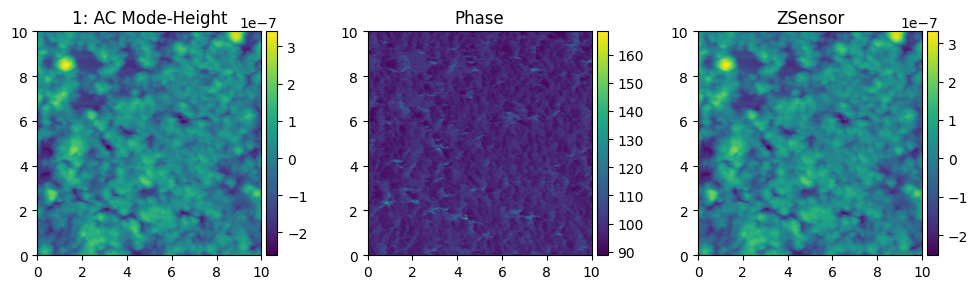

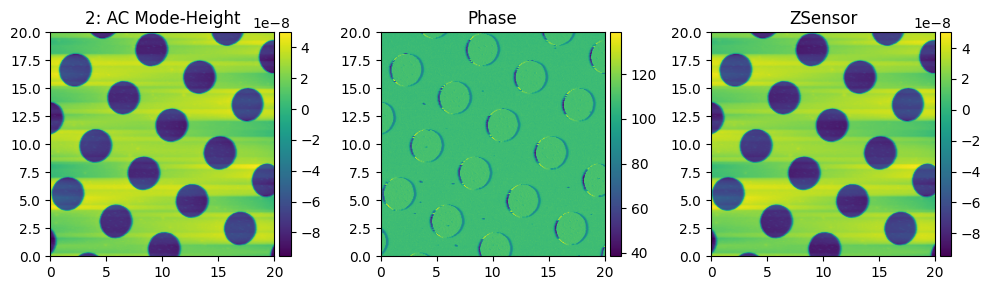

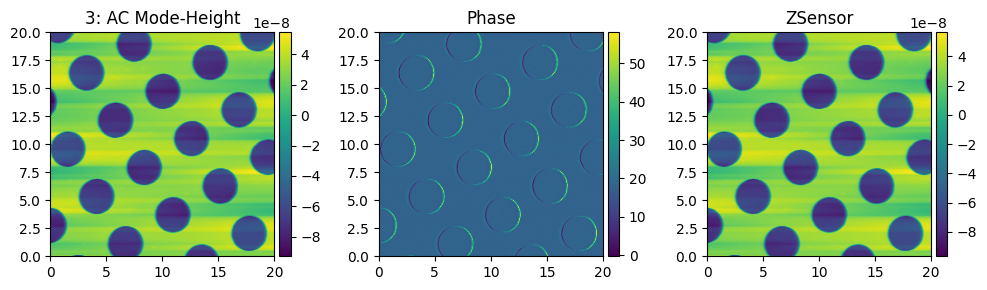

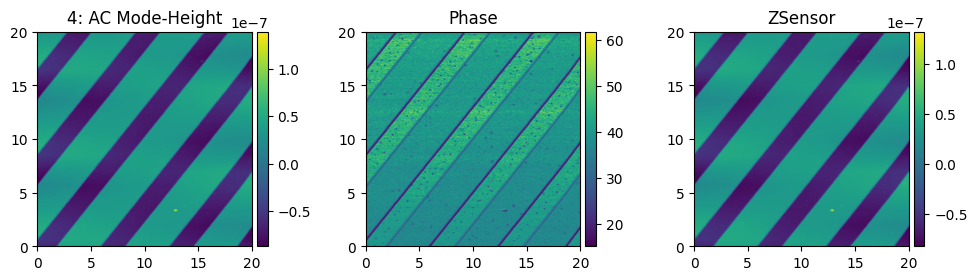

In [10]:
# Only the AC mode and the Height Phase and ZSensor channels will be displayed
folder = 'ibw'

fnames, ibw_data = display_ibw_folder(folder=folder, mode='AC Mode', key=['Height', 'Phase', 'ZSensor'])

# Quickly open one ibw file

ibw  sample_data  test.png


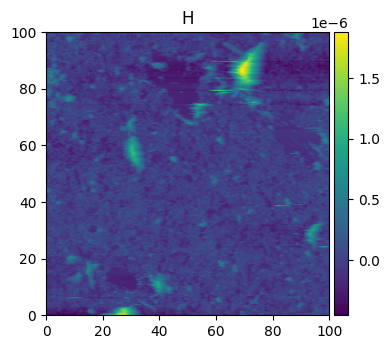

In [11]:
file_name = 'ibw/H120009.ibw'

t = display_ibw(file_name, key=['Height'], titles='Height', save='test')
!ls

# Plot Hysteresis loop spectrum

PTO_Loc2_SS_0002.ibw
PTO_Loc5_SS_0004.ibw


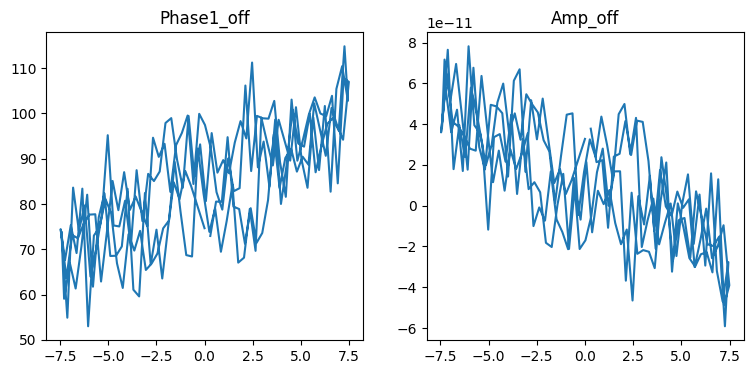

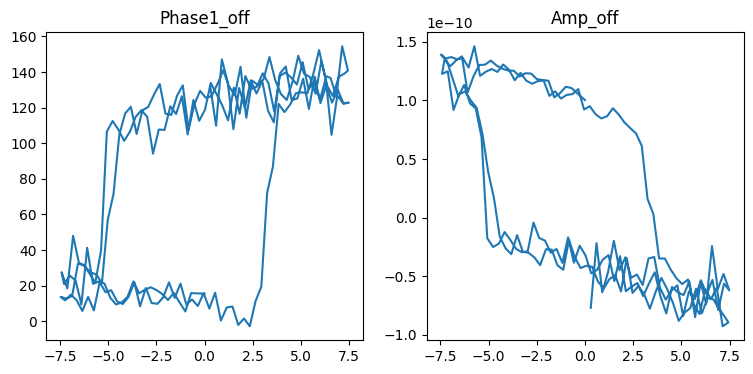

In [12]:
folder = 'ibw'

fnames = sorted(os.listdir(folder))

for file in fnames:
    if file.endswith('.ibw'):
        temp = load_ibw(os.path.join(folder, file))
        if len(temp.data.shape) == 2:
            print(file)
            t = load_ibw(os.path.join(folder, file), ss=True)

            fig, ax=plt.subplots(1,2,figsize=[9,4])
            ax[0].plot(t.bias, t.phase1_off)
            ax[0].set_title('Phase1_off')
            ax[1].plot(t.bias, t.amp_off)
            ax[1].set_title('Amp_off')
